In [11]:
# auto reload modules when they are changed
%load_ext autoreload
%autoreload 2

In [105]:
import mne
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import compress

In [13]:
from src.load_data import load_retinotopy_data

In [18]:
data = load_retinotopy_data()

Loading /Users/rhotter/code/signal-classifier/data/Retinotopy/Steve/steve-scan9-Sep-19-2023-7-03-PM_real.snirf
Loading /Users/rhotter/code/signal-classifier/data/Retinotopy/Steve/steve-scan3-Sep-18-2023-8-31-PM-real.snirf
Loading /Users/rhotter/code/signal-classifier/data/Retinotopy/Steve/steve-scan4-Sep-18-2023-8-46-PM-real.snirf
Loading /Users/rhotter/code/signal-classifier/data/Retinotopy/Steve/steve-scan5-Sep-18-2023-9-09-PM-real.snirf
Loading /Users/rhotter/code/signal-classifier/data/Retinotopy/Steve/steve-scan2-Sep-18-2023-8-09-PM-real.snirf
Loading /Users/rhotter/code/signal-classifier/data/Retinotopy/Steve/steve-scan6-Sep-18-2023-9-21-PM-real.snirf


In [37]:
intensity = data[1]

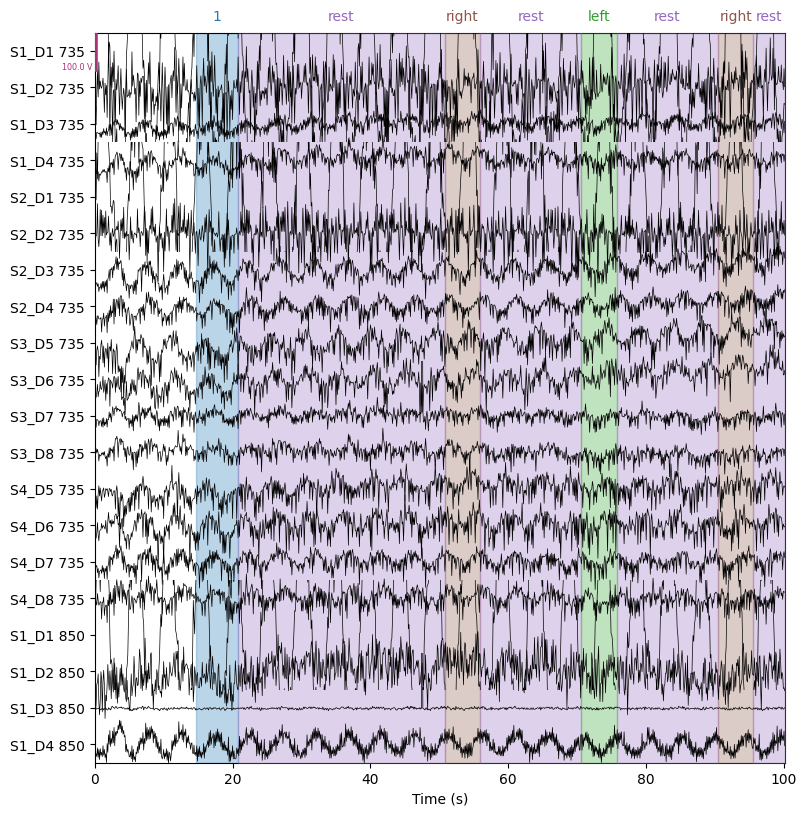

In [78]:
intensity.plot(scalings={'fnirs_cw_amplitude': 50}, show_scrollbars=False, duration=100)
plt.show()

In [154]:
events = []
event_id = []
for data_i in data:
    (events_i, event_id_i) = mne.events_from_annotations(data_i)
    events.append(events_i)
    event_id.append(event_id_i)


Used Annotations descriptions: ['1', 'end', 'left', 'rest', 'right']
Used Annotations descriptions: ['1', 'end', 'left', 'rest', 'right']
Used Annotations descriptions: ['1', 'end', 'left', 'rest', 'right']
Used Annotations descriptions: ['1', 'end', 'left', 'rest', 'right']
Used Annotations descriptions: ['1', 'end', 'left', 'rest', 'right']
Used Annotations descriptions: ['1', 'end', 'left', 'rest', 'right']


In [148]:
od = []
for data_i in data:
    od_i = mne.preprocessing.nirs.optical_density(data_i)
    od.append(od_i)
    # od.plot(n_channels=len(od.ch_names), duration=100, show_scrollbars=False, scalings={'fnirs_od': 0.1})
    # plt.show()

Reading 0 ... 5349  =      0.000 ...   534.900 secs...
Reading 0 ... 4663  =      0.000 ...   466.300 secs...
Reading 0 ... 4614  =      0.000 ...   461.400 secs...
Reading 0 ... 6194  =      0.000 ...   619.400 secs...
Reading 0 ... 5349  =      0.000 ...   534.900 secs...
Reading 0 ... 4855  =      0.000 ...   485.500 secs...


In [171]:
conc = []
for od_i in od:
    conc_i = mne.preprocessing.nirs.beer_lambert_law(od_i)
    conc_i = conc_i.filter(0.05, 0.5, fir_design='firwin2', verbose=False)
    conc.append(conc_i)
# conc.plot(n_channels=len(conc.ch_names), duration=100, show_scrollbars=False)
# plt.show()

In [211]:
epochs = []

for i in range(len(conc)):
    epochs_i = mne.Epochs(
        conc[i],
        events[i],
        event_id=event_id[i],
        tmin=-6,
        tmax=30,
        reject=None,
        # reject_by_annotation=True,
        # proj=True,
        baseline=(None, 0),
        preload=True,
        detrend=None,
        verbose=False,
    )
    epochs.append(epochs_i)

epochs = mne.concatenate_epochs(epochs)

Not setting metadata
245 matching events found
Applying baseline correction (mode: mean)


/var/folders/0m/ckfdqrb51qx5mt8j0s6pz07m0000gn/T/ipykernel_74851/3482737204.py:20: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(epochs)


In [212]:
left_channels = ["S2_D3 hbo", "S2_D4 hbo"]
right_channels = ["S3_D5 hbo", "S3_D6 hbo"]

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


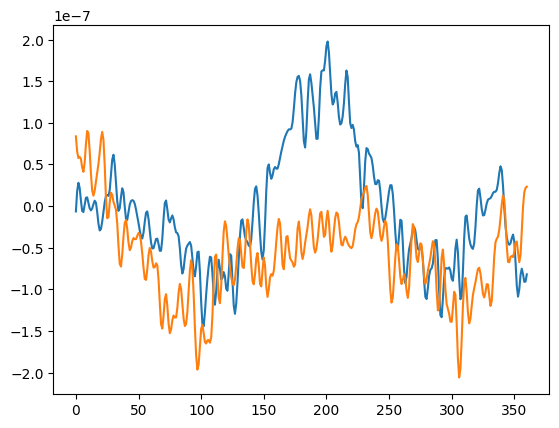

In [216]:
left_average = epochs["left"].pick(right_channels).average()
right_average = epochs["right"].pick(right_channels).average()

plt.plot(left_average.data[1])
plt.plot(right_average.data[1])
plt.show()

Not setting metadata
60 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"


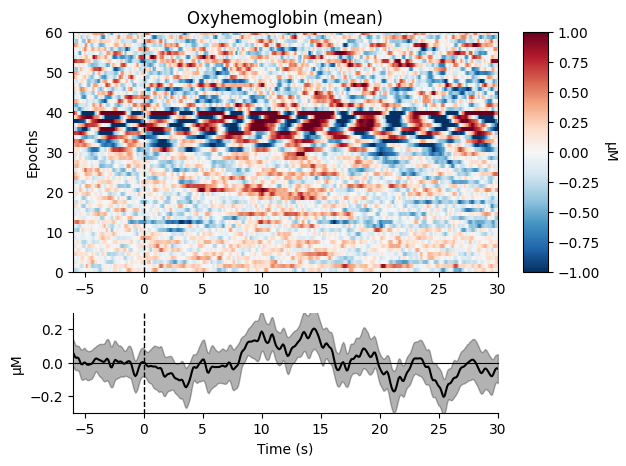

In [217]:
epochs["right"].pick(left_channels).plot_image(
    combine="mean",
    vmin=-1,
    vmax=1,
    ts_args=dict(ylim=dict(hbo=[-0.3, 0.3], hbr=[-0.3, 0.3])),
)
plt.show()

Not setting metadata
60 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"


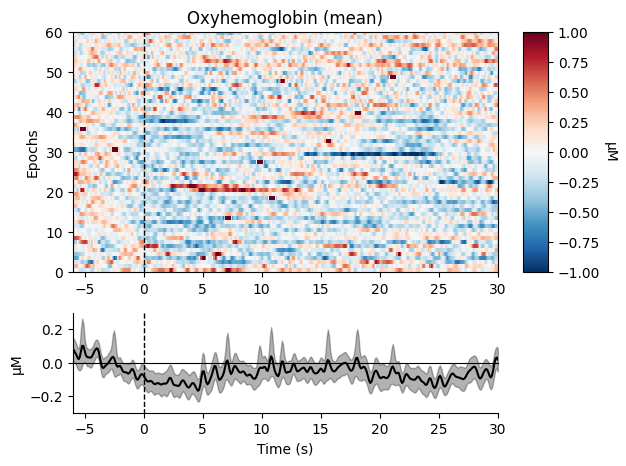

In [218]:
epochs["right"].pick(right_channels).plot_image(
    combine="mean",
    vmin=-1,
    vmax=1,
    ts_args=dict(ylim=dict(hbo=[-0.3, 0.3], hbr=[-0.3, 0.3])),
)
plt.show()